# Google Chrome Data Analysis

In [215]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta, time
from scipy.ndimage.filters import gaussian_filter1d

## Processing

In [261]:
# Get this file from takeout.google.com
# To speed up the process, only select "Google Chrome"
# and within "Google Chrome" only select "Browser History".
# This file should be ready in a couple minutes
with open(r'BrowserHistory.json', encoding='utf8') as file:
    data = json.load(file)
data = data['Browser History']
data[0]

googles = []
search_words = {}
search_phrases = {}
bings = []
bing_search_words = {}
bing_search_phrases = {}
times = []
# Histogram of when sites are loaded. 
# This shows most/least active time of day
daily_minute = [0] * 1440
# Number of visits for each day
daily_visits = {}
urls = {}
longest_url = data[0]['url']
shortest_url = data[0]['url']

for entry in data:

    # Most visited url
    # Method: Get up to the third '/'
    indices = [i for i, a in enumerate(entry['url']) if a == '/']
    # Skip things that we don't care about, like "about:blank"
    if len(indices) < 3:
        continue
    site = entry['url'][:indices[2]+1]
    if site in urls.keys():
        urls[site] += 1
    else:
        urls[site] = 1

    # Number of Google Searches
    if len(entry['url']) > 30 and entry['url'][:30] == 'https://www.google.com/search?':
        googles.append(entry)
        
        # Search phrase frequency
        phrase = entry['title'][:-16] # remove the " - Google Search"
        if phrase in search_phrases.keys():
            search_phrases[phrase] += 1
        else:
            search_phrases[phrase] = 1
            
        # Search word frequency
        # Average English vocabulary: 20000 activate words, 40000 passive
        keywords = phrase.split(' ')
        for word in keywords:
            if word in search_words.keys():
                search_words[word] += 1
            else:
                search_words[word] = 1
        
    # Number of Bing searches https://www.bing.com/search?
    if len(entry['url']) > 27 and entry['url'][:28] == 'https://www.bing.com/search?':
        bings.append(entry)
        
        # Search phrase frequency
        phrase = entry['url'][28 : entry['url'].index('&')]
        phrase = phrase.replace('%20', ' ')
        if phrase in bing_search_phrases.keys():
            bing_search_phrases[phrase] += 1
        else:
            bing_search_phrases[phrase] = 1
            
        # Search word frequency
        # Average English vocabulary: 20000 activate words, 40000 passive
        keywords = phrase.split(' ')
        for word in keywords:
            if word in bing_search_words.keys():
                bing_search_words[word] += 1
            else:
                bing_search_words[word] = 1

    # Average time of day
    time = entry['time_usec'] / 1000000.0
    time = datetime.fromtimestamp(time) #.strftime('%Y-%m-%d %H:%M:%S')
    times.append(time)
    time_idx = time.hour*60 + time.minute
    daily_minute[time_idx] += 1

    # Number of webpages per day
    day_idx = time.strftime('%Y-%m-%d')
    if day_idx in daily_visits.keys():
        daily_visits[day_idx] += 1
    else:
        daily_visits[day_idx] = 1
        
    # Longest URL vs Shortest URL
    if len(entry['url']) > len(longest_url):
        longest_url = entry['url']
    elif len(entry['url']) < len(shortest_url):
        shortest_url = entry['url']


In [270]:
print('You made {} Google searches with {} unique phrases and {} unique words'
      .format(len(googles), len(search_phrases), len(search_words)))
print()
print('You made {} Bing searches with {} unique phrases and {} unique words'
      .format(len(bings), len(bing_search_phrases), len(bing_search_words)))
print()
print('The longest URL you visited was {} characters and the shortest was {} characters'
      .format(len(longest_url),len(shortest_url)))
print()
combined_searches = dict(search_words)
for key, val in bing_search_words.items():
    if key in combined_searches:
        combined_searches[key] += val
    else:
        combined_searches[key] = val
combined_searches = sorted(combined_searches.items(), key=lambda x: x[1], reverse=True)
print('Your most popular words to use in search are:')
for i in range(30):
    print("\t'{}' {} times".format(combined_searches[i][0], combined_searches[i][1]))


You made 17188 Google searches with 11829 unique phrases and 12227 unique words

You made 0 Bing searches with 0 unique phrases and 0 unique words

The longest URL you visited was 7698 characters and the shortest was 10 characters

Your most popular words to use in search are:
	'to' 1363 times
	'of' 1145 times
	'python' 788 times
	'in' 690 times
	'how' 673 times
	'the' 638 times
	'is' 492 times
	'madison' 477 times
	'for' 473 times
	'a' 447 times
	'and' 402 times
	'weather' 383 times
	'phd' 379 times
	'science' 370 times
	'uw' 306 times
	'on' 295 times
	'date' 265 times
	'release' 254 times
	'with' 251 times
	'bokeh' 248 times
	'list' 238 times
	'android' 234 times
	'computer' 234 times
	'what' 230 times
	'reddit' 210 times
	'movie' 208 times
	'pandas' 206 times
	'not' 202 times
	'from' 191 times
	'get' 190 times


## Daily Activity

You visited 121570 sites in the last 369 days!
That's 329 sites per day

Your most active days were:
	1) 2019-10-30 with 1294 webpage visits
	2) 2019-11-25 with 1186 webpage visits
	3) 2019-12-02 with 1181 webpage visits
	4) 2019-10-16 with 1136 webpage visits
	5) 2019-12-30 with 1056 webpage visits


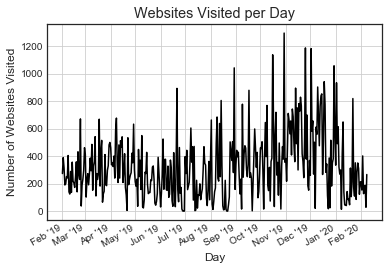

In [278]:
%matplotlib inline
daily = dict(daily_visits)
sorted_visits = sorted(daily.items(), key=lambda x:x[1], reverse=True)

total = 0
for day in sorted_visits:
    total += day[1]
ave = int(total / len(sorted_visits))
print('You visited {} sites in the last {} days!'.format(len(data), len(sorted_visits)))
print('That\'s {} sites per day'.format(ave))
print()
print("Your most active days were:")
for i in range(5):
    print("\t{}) {} with {} webpage visits".format(str(i+1), sorted_visits[i][0], sorted_visits[i][1]))

start_day = datetime.strptime(list(daily.items())[-1][0], '%Y-%m-%d')
end_day = datetime.strptime(list(daily.items())[0][0], '%Y-%m-%d')
date_list = mdates.drange(start_day, end_day+timedelta(days=1), timedelta(days=1))
for date in date_list:
    if not mdates.num2date(date).strftime('%Y-%m-%d') in daily.keys():
        daily[mdates.num2date(date).strftime('%Y-%m-%d')] = 0

sorted_visits = sorted(daily.items(), key = lambda x:datetime.strptime(x[0], '%Y-%m-%d'), reverse=False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().axes.set_ylabel('Number of Websites Visited')
plt.gca().axes.set_xlabel('Day')
plt.title('Websites Visited per Day')

plt.plot(date_list, [x[1] for x in sorted_visits], '-', color='black')
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

## Average Daily Usage

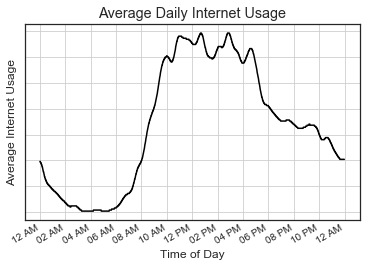

It looks like you're most active around 12:12 PM and least active around 03:12 AM


In [279]:
start_time = datetime(12, 12, 12, 0, 0)
end_time = start_time + timedelta(hours=24)
time_list = mdates.drange(start_time, end_time, timedelta(minutes=1))
hour_list = mdates.drange(start_time, end_time+timedelta(hours=1), timedelta(hours=2))
daily_minute_smoothed = gaussian_filter1d(daily_minute, sigma=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
plt.xticks(hour_list)
plt.gca().axes.set_yticklabels([])
plt.gca().axes.set_ylabel('Average Internet Usage')
plt.gca().axes.set_xlabel('Time of Day')
plt.title('Average Daily Internet Usage')
plt.plot(time_list, daily_minute_smoothed, '-', color='black');
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

max_index = list(daily_minute_smoothed).index(max(daily_minute_smoothed))
min_index = list(daily_minute_smoothed).index(min(daily_minute_smoothed))
most_active = (mdates.num2date(time_list[max_index]).strftime('%I:%m %p'))
least_active = (mdates.num2date(time_list[min_index]).strftime('%I:%m %p'))
print('It looks like you\'re most active around {} and least active around {}'
      .format(most_active, least_active))